## Семинар 15: "Обучение с подкреплением 2"

ФИО: Валинуров Денис Юрьевич

###  FrozenLake


<img src="http://vignette2.wikia.nocookie.net/riseoftheguardians/images/4/4c/Jack's_little_sister_on_the_ice.jpg/revision/latest?cb=20141218030206" alt="a random image to attract attention" style="width: 400px;"/>



In [1]:
import gym
import numpy as np 
import random
from itertools import product, count
from collections import namedtuple
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import math

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


In [2]:
#create a single game instance
env = gym.make("FrozenLake-v0")

#start new game
env.reset();

In [3]:
!pip install gym[atari]

You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
# display the game state
env.render()


SFFF
FHFH
FFFH
HFFG


### legend

![img](https://cdn-images-1.medium.com/max/800/1*MCjDzR-wfMMkS0rPqXSmKw.png)

## Задание 1.
Подберите значения alpha и epsilon и найдите приближение оптимальной Q-функции для Frozen Lake.

In [5]:

class QLearn:
    def __init__(self, actions, epsilon=0.1, alpha=0.2, gamma=0.9):
        self.q = {}
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.actions = actions

    def getQ(self, state, action):
        return self.q.get((state, action), 0.0)

    def learnQ(self, state, action, reward, value):
        oldv = self.q.get((state, action), None)

        if oldv is None:
            self.q[(state, action)] = reward
        else:
            self.q[(state, action)] = oldv + self.alpha * (value - oldv)

    def chooseAction(self, state):
        if random.random() < self.epsilon:
            action = random.choice(self.actions)
        else:
            q = [self.getQ(state, a) for a in self.actions]
            maxQ = max(q)
            count = q.count(maxQ)
            if count > 1:
                best = [i for i in range(len(self.actions)) if q[i] == maxQ]
                i = random.choice(best)
            else:
                i = q.index(maxQ)

            action = self.actions[i]
        return action

    def learn(self, state1, action1, reward, state2):
        maxqnew = max([self.getQ(state2, a) for a in self.actions])
        self.learnQ(state1, action1, reward, reward + self.gamma*maxqnew)

In [6]:
qlearn = QLearn(actions=range(env.env.nA), gamma=1, epsilon=0.1, alpha=0.2)

In [7]:
def run_episode_qlearn_learn(env, qlearn, gamma = 1.0, render = False):
    obs = env.reset()
    total_reward = 0
    step_idx = 0
    while True:
        if render:
            env.render()
        action = qlearn.chooseAction(obs)
        obs_new, reward, done, _ = env.step(action)
        qlearn.learn(obs, action, reward, obs_new)
        obs = obs_new
        total_reward += (gamma ** step_idx * reward)
        step_idx += 1
        if done:
            break
    return total_reward

In [8]:
def run_episode_qlearn(env, qlearn, gamma = 1.0, render = False):
    obs = env.reset()
    total_reward = 0
    step_idx = 0
    while True:
        if render:
            env.render()
        action = qlearn.chooseAction(obs)
        obs_new, reward, done, _ = env.step(action)
        obs = obs_new
        total_reward += (gamma ** step_idx * reward)
        step_idx += 1
        if done:
            break
    return total_reward

In [9]:
def evaluate_qlearn(env, qlearn, gamma = 1.0,  n = 100):
    scores = [
            run_episode_qlearn(env, qlearn, gamma = gamma, render = False)
            for _ in range(n)]
    return np.mean(scores)

In [10]:
max_reward, max_alpha, max_epsilon = 0, 0, 0
for alpha, epsilon in product(np.linspace(0, 1, 11), np.linspace(0, 1, 11)):
    qlearn = QLearn(actions=range(env.env.nA), epsilon=epsilon, alpha=alpha)
    for _ in range(10000):
        run_episode_qlearn_learn(env, qlearn)
    avg_reward = evaluate_qlearn(env, qlearn, n=1000)
    if avg_reward > max_reward:
        max_alpha, max_epsilon, max_reward = alpha, epsilon, avg_reward
print max_alpha, max_epsilon, max_reward

0.7000000000000001 0.1 0.411


## Задание 2.
Обучите сеть DQN для среды http://gym.openai.com/envs/Pong-v0/ 

In [11]:
env = gym.make('Pong-v0')

In [12]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [13]:


class DQN(nn.Module):
    def __init__(self, output_size=3):
        super(DQN, self).__init__()
        self.features = nn.Sequential(nn.Conv2d(3, 16, 2, stride=4),
                                      nn.ReLU(),
                                      nn.Conv2d(16, 32, 2, stride=4),
                                      nn.ReLU(),
                                     )
        
        self.classifier = nn.Sequential(nn.Linear(32 * (210 / 4 / 4) * (160 / 4 / 4), 256),
                                        nn.ReLU(),
                                        nn.Linear(256, output_size)
                                       )
    
    def forward(self, x):
        batch_size = x.shape[0] // 210
        x = x.reshape((batch_size, 3, 210, 160))
        x = self.features(x)
        x = x.view(batch_size, 32 * (210 / 4 / 4) * (160 / 4 / 4))
        x = self.classifier(x)
        return x



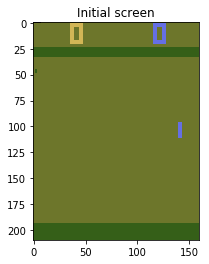

In [14]:
def get_screen():
    screen = env.render(mode='rgb_array')
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255.0
    screen = torch.from_numpy(screen)
    return screen


env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).numpy(),
           interpolation='none')
plt.title('Initial screen')
plt.show()

In [15]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.ByteTensor(map(lambda s: s is not None,
                                          batch.next_state))

    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)    
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)
    next_state_values = torch.zeros(BATCH_SIZE)

    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()


In [16]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 5

policy_net = DQN()
target_net = DQN()
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done 
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return torch.tensor([[policy_net(state).argmax(1)]], dtype=torch.int64)
    else:
        return torch.tensor([[random.randrange(2)]], dtype=torch.int64)

In [17]:
def reorder(x):
        if x == 1:
            return 4
        elif x == 2:
            return 5
        else:
            return 0

episode 0


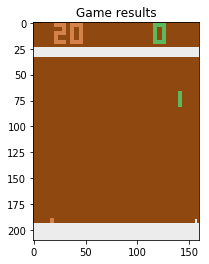

episode 1


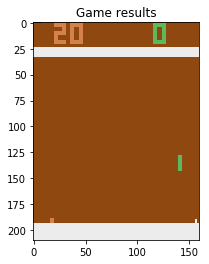

episode 2


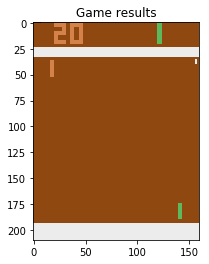

episode 3


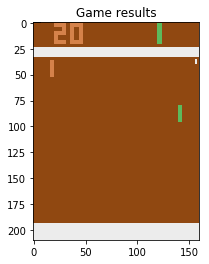

episode 4


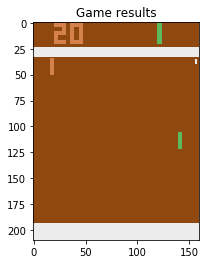

episode 5


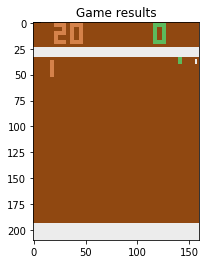

episode 6


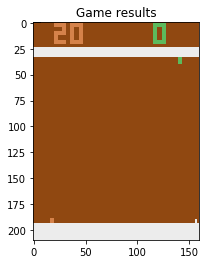

episode 7


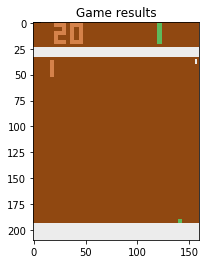

episode 8


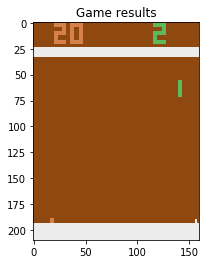

episode 9


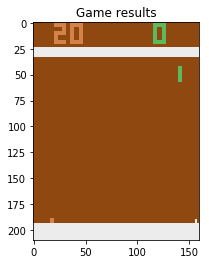

episode 10


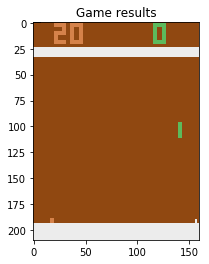

episode 11


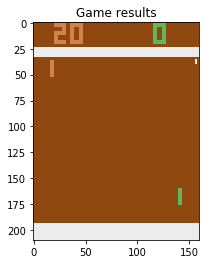

episode 12


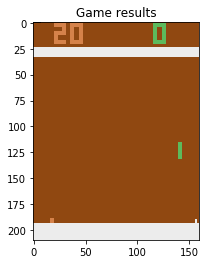

episode 13


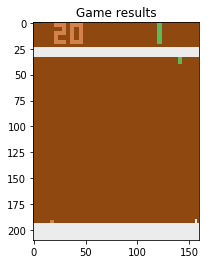

episode 14


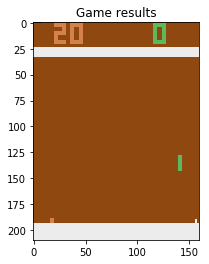

episode 15


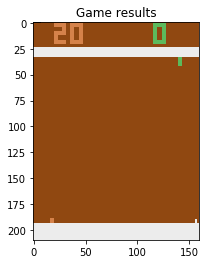

episode 16


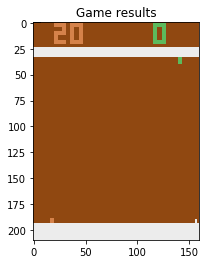

episode 17


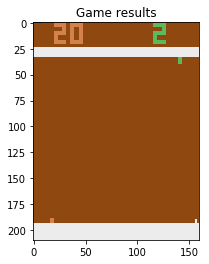

episode 18


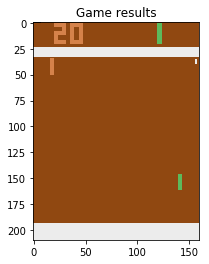

episode 19


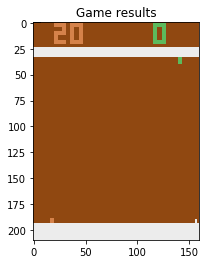

episode 20


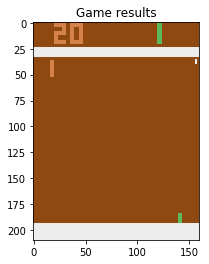

episode 21


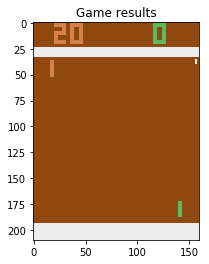

episode 22


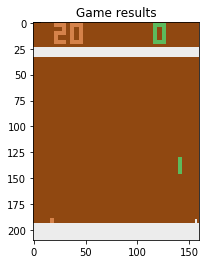

episode 23


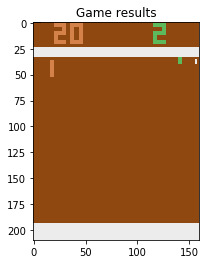

episode 24


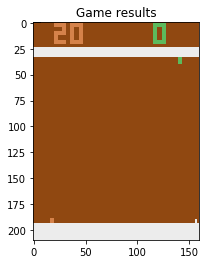

episode 25


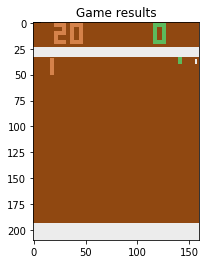

episode 26


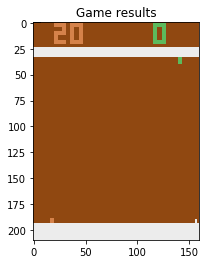

episode 27


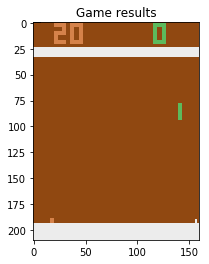

episode 28


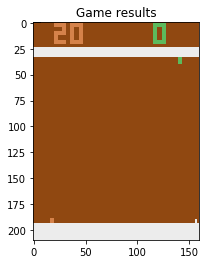

episode 29


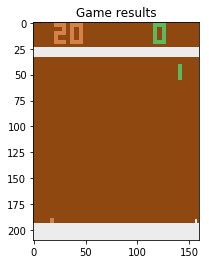

episode 30


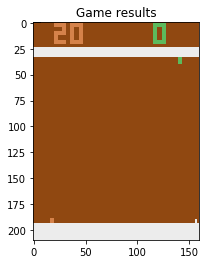

episode 31


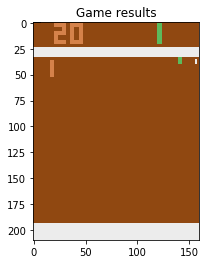

episode 32


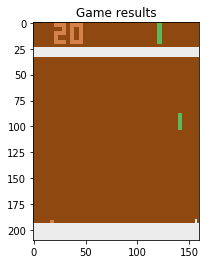

episode 33


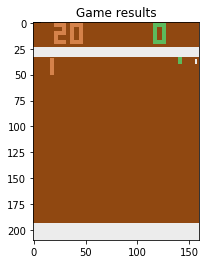

episode 34


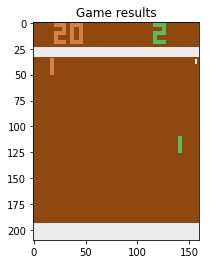

episode 35


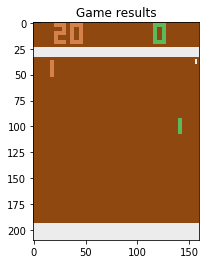

episode 36


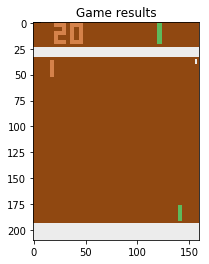

episode 37


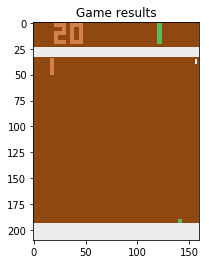

episode 38


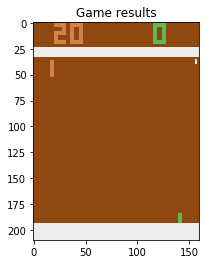

episode 39


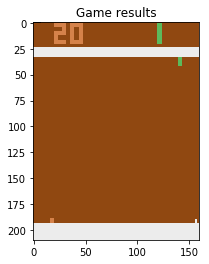

episode 40


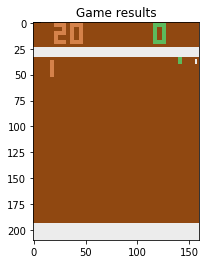

episode 41


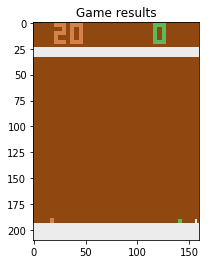

episode 42


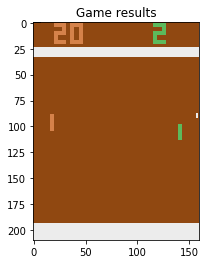

episode 43


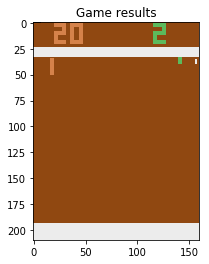

episode 44


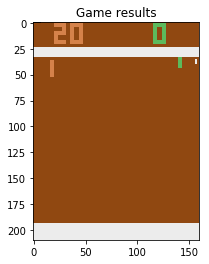

episode 45


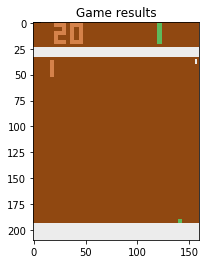

episode 46


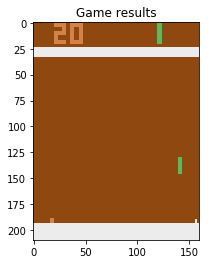

episode 47


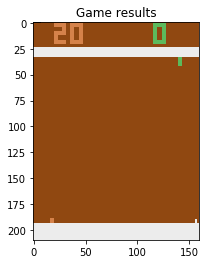

episode 48


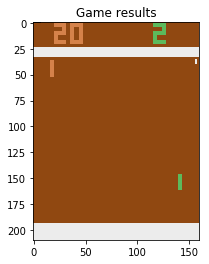

episode 49


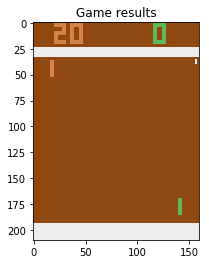

Complete


In [18]:
num_episodes = 50
for i_episode in range(num_episodes):
    print 'episode {}'.format(i_episode)
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in count():
        action = select_action(state)
        _, reward, done, _ = env.step(reorder(action.item()))
        reward = torch.tensor([reward])

        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        memory.push(state, action, next_state, reward)
        state = next_state
        optimize_model()
        if done:
            plt.figure()
            plt.imshow(get_screen().cpu().squeeze(0).numpy(),
                       interpolation='none')
            plt.title('Game results')
            plt.show()
            break

    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')

## 

In [386]:
env.close()